In [1]:
import tensorflow.keras.applications as models
from Dataset import *
import tensorflow as tf
import random as rn
import pandas as pd
import numpy as np
import os

sd = 123
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

2022-04-03 11:40:35.090335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 11:40:35.100085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 11:40:35.100766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Num GPUs Available:  1


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
batch_size = 16
train_dt1 = data_batch(train1, cols, product = 'packages', shuffle=True, batch_size=batch_size)
val_dt1 = data_batch(val1, cols, product = 'packages', shuffle=False, batch_size=batch_size)

STEPS_PER_EPOCH = 864 // batch_size

864 (array([1.]), array([864])) 2 43
100 (array([1.]), array([100])) 2 43


In [20]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train1[train1['product']==1].coarse_label),
                                                 y = train1[train1['product']==1].coarse_label)
class_weights = dict(zip(np.unique(train1[train1['product']==1].coarse_label), class_weights))
a = {}
for i in range(0,43):
    if i in class_weights.keys(): a[i] = class_weights[i]
    else: a[i]=0

In [21]:
np.unique(train1[train1['product']==1].coarse_label,return_counts=True)

(array([19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([247, 182,  33,  32,  48,  30,  51,  60, 181]))

In [22]:
np.unique(val1[val1['product']==1].coarse_label,return_counts=True)

(array([19, 20, 21, 22, 23, 25, 27]), array([29, 26,  5,  5,  5, 10, 20]))

In [23]:
np.unique(test1[test1['product']==1].coarse_label,return_counts=True)

(array([19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([219, 164,  30,  31,  41,  19,  47,  58, 172]))

In [24]:
import tensorflow.keras.applications as models
def model_fn2(input_shape, output_shape):
    vgg16 = models.inception_v3.InceptionV3(weights='imagenet', include_top=False,input_shape=input_shape)
    vgg16.trainable = True
    input1 = tf.keras.Input(shape=(224,224,3))
    # x1 = tf.keras.applications.vgg16.preprocess_input(input1)
    x1 = vgg16(input1)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    out_all = tf.keras.layers.Dense(output_shape, activation='softmax')(x1)
    model = tf.keras.Model(input1, outputs=out_all)
    return model
model2 = model_fn2(input_shape = (224,224,3), output_shape = 43)

In [25]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='categorical_crossentropy',metrics=['accuracy'])
es2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=2, min_lr=0.0000001)
history2 = model2.fit(train_dt1,steps_per_epoch = STEPS_PER_EPOCH,epochs =20,
                      validation_data=val_dt1,verbose=1,callbacks=[es2], class_weight=a)

Epoch 1/20
54/54 [==============================] - 18s 167ms/step - loss: 1.6017 - accuracy: 0.5509 - val_loss: 1.3690 - val_accuracy: 0.5500
Epoch 2/20
54/54 [==============================] - 8s 146ms/step - loss: 0.1184 - accuracy: 0.9769 - val_loss: 0.8213 - val_accuracy: 0.7100
Epoch 3/20
54/54 [==============================] - 8s 148ms/step - loss: 0.0478 - accuracy: 0.9942 - val_loss: 0.6559 - val_accuracy: 0.7700
Epoch 4/20
54/54 [==============================] - 8s 147ms/step - loss: 0.0215 - accuracy: 0.9954 - val_loss: 0.5255 - val_accuracy: 0.8600
Epoch 5/20
54/54 [==============================] - 8s 146ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.4514 - val_accuracy: 0.8700
Epoch 6/20
54/54 [==============================] - 8s 144ms/step - loss: 0.0197 - accuracy: 0.9942 - val_loss: 0.4471 - val_accuracy: 0.8700
Epoch 7/20
54/54 [==============================] - 8s 144ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.4027 - val_accuracy: 0.8800
Epoch

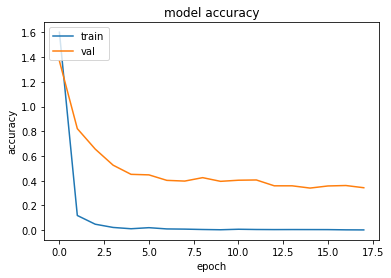

In [26]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
test_dt1 = data_batch(test1, cols, product = 'packages', shuffle=False, batch_size=1)

781 (array([1.]), array([781])) 2 43


In [28]:
y_pred2 = model2.predict(test_dt1)
y_pred3 = np.argmax(y_pred2, axis=-1)
y_true2 = np.array([int(np.argmax(y.numpy()[0], axis=-1)) for x,y in test_dt1])
y_pred3.shape,y_true2.shape

((781,), (781,))

In [30]:
from sklearn.metrics import confusion_matrix,f1_score,precision_score, recall_score, accuracy_score

pre = precision_score(y_true2,y_pred3, average='macro')
rec = recall_score(y_true2,y_pred3, average='macro')
f_score = f1_score(y_true2,y_pred3, average='macro')
acc = accuracy_score(y_true2,y_pred3)
print(pre, rec, f_score, acc)

0.9694402443884369 0.9570690095538951 0.9623660236429328 0.9731113956466069


In [31]:
confusion_matrix(y_pred3,y_true2)

array([[219,   5,   0,   0,   4,   0,   0,   0,   1],
       [  0, 158,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,  30,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  31,   1,   0,   0,   0,   0],
       [  0,   1,   0,   0,  30,   1,   0,   1,   1],
       [  0,   0,   0,   0,   1,  18,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  47,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57,   0],
       [  0,   0,   0,   0,   3,   0,   0,   0, 170]])

In [32]:
tf.keras.models.save_model(model2,'part2.h5')